In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_PROJECT"] = "reqmgmt"

In [ ]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:

    
    os.environ["GROQ_API_KEY"] = getpass.getpass("")

In [ ]:
os.environ["GROQ_API_KEY"] = ""

In [38]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="openai/gpt-oss-120b")

In [ ]:

ai_msg = llm.invoke("hi")
ai_msg.content

'Hello! How can I help you today?'

: 

In [5]:
print(ai_msg.content)

Hello! How can I help you today?


In [6]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: h:\akash\git\CoherenceAI


In [7]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [8]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

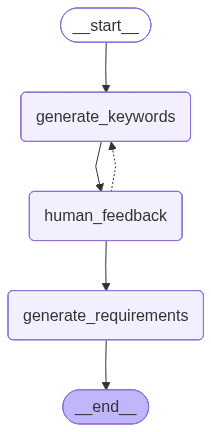

In [ ]:
from langgraph.graph import StateGraph, MessagesState, END

from langchain_core.messages import SystemMessage
from pydantic import BaseModel, Field
from typing import List
from langgraph.checkpoint.memory import MemorySaver
# -----------------------------
# Pydantic Models
# -----------------------------
class KeywordOutput(BaseModel):
    keywords: List[str] = Field(..., description="5 keywords, each 3 words long")

class RequirementsOutput(BaseModel):
    requirements: List[str] = Field(..., description="5 formal requirements derived from selected keyword")


class RisksOutput(BaseModel):
    Risks: List[str] = Field(..., description="Risk for each requirement")



# -----------------------------
# Graph State
# -----------------------------
class KeywordState(MessagesState):
    requirement_description: str
    keyword_output: KeywordOutput | None = None
    selected_keyword: str | None = None
    requirements_output: RequirementsOutput | None = None


# -----------------------------
# Nodes (example placeholders)
# -----------------------------
def generate_keywords(state: KeywordState):
    # LLM call logic here

    from langchain_core.prompts import ChatPromptTemplate

    print("\n✅ ================Entered Generated Keywords===============================:")
    prompt = ChatPromptTemplate.from_template("""
    You are an expert requirement analyst.  
    Given the following requirement description:

    "{requirement_description}"

    Generate exactly 5 keywords, each containing 3 words, as JSON list.
    """)

    # Use structured output
    llm_structured = llm.with_structured_output(KeywordOutput)
    result = (prompt | llm_structured).invoke({"requirement_description": state["requirement_description"]})

    state["keyword_output"] = result
    state["messages"].append(SystemMessage(content=f"Generated keywords: {result.keywords}"))


    print("=== Current State ===")
    for k, v in state.items():
        print(f"{k}: {v}")
    return state


def human_feedback(state: KeywordState):

    """Interrupt node: user selects keyword"""
    print("\n✅ ================Entered human feedback===============================:")
 
    # for i, kw in enumerate(state["keyword_output"].keywords, 1):
    #     print(f"{i}. {kw}")

    while True:
        choice = input("Select a keyword by number: ")
        # print("choice is ",choice)
        # print("you have selected", state["keyword_output"].keywords[int(choice)-1])
        #if choice.isdigit() and 1 <= int(choice) <= len(state["keyword_output"].keywords):
        state["selected_keyword"] = state["keyword_output"].keywords[int(choice)-1]
        # print(state.selected_keyword) 
        break
    
    print("=== Current State ===")
    for k, v in state.items():
        print(f"{k}: {v}")
    return state

def should_continue(state):
    print("\n✅ ================Entered should continue===============================:")
    feedback = (state["selected_keyword"] or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "generate_requirements"
    return END

def generate_requirements(state: KeywordState):
    # LLM call logic to generate 5 requirements

    from langchain_core.prompts import ChatPromptTemplate
    print("\n✅ ================Entered generate_requirements===============================:")
    
 
    prompt = ChatPromptTemplate.from_template("""
    You are an expert requirement analyst.  
    Given the requirement description "{requirement_description}" and keyword "{selected_keyword}", generate 5 formal requirements as JSON list.
    """)
    llm_structured = llm.with_structured_output(RequirementsOutput)
    #print("llm_structured is ", llm_structured)
    result = (prompt | llm_structured).invoke({
    "selected_keyword": state["selected_keyword"],
    "requirement_description": state["requirement_description"]
})
    #print("result is ", result)
    state["requirements_output"] = result

    #print("state.requirements_output is ", state["requirements_output"])
    #print("result.requirements is ", result.requirements)
    
    state["messages"].append(SystemMessage(content=f"Generated requirements: {result.requirements}"))

    print("=== Current State ===")
    for k, v in state.items():
        print(f"{k}: {v}")
    return state


# -----------------------------
# Build Graph
# -----------------------------
builder = StateGraph(KeywordState)
builder.add_node("generate_keywords", generate_keywords)
builder.add_node("human_feedback", human_feedback)
builder.add_node("generate_requirements", generate_requirements)

builder.add_edge("generate_keywords", "human_feedback")
# builder.add_edge("human_feedback", "generate_requirements")
# builder.add_edge("generate_requirements", END)


builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["generate_keywords",
                        "generate_requirements"])
builder.add_edge("human_feedback", "generate_requirements")
builder.add_edge("generate_requirements", END)


builder.set_entry_point("generate_keywords")

# -----------------------------
# Compile graph with memory & interrupt
# -----------------------------
memory = MemorySaver()
graph = builder.compile( checkpointer=memory)



# -----------------------------
# Run with thread isolation
# -----------------------------
thread = {"configurable": {"thread_id": 1}}


from IPython.display import Image, display

# Draw the graph as a Mermaid PNG
graph_image = graph.get_graph().draw_mermaid_png()

# Display inline in notebook
display(Image(graph_image))




In [28]:
state = {
    "requirement_description": "The benefits of adopting LangGraph as an agent framework",
    "messages": [],
    "keyword_output": None,
    "selected_keyword": None,
    "requirements_output": None
}

# Run the entire graph; input() will pause it once
for event in graph.stream(state, thread, stream_mode="values"):

    print("event", event)
    if "keyword_output" in event and event["keyword_output"]:
        # print("\n⚡ Current Keywords:")
        print(" -----------------------------")
        for kw in event["keyword_output"].keywords:
            
            print(" -", kw)
    if "requirements_output" in event and event["requirements_output"]:
        print(" -----------------------------")
        # print("\n✅ Final Generated Requirements:")
        for kw1 in event["requirements_output"].requirements:
           
            print(" -", kw1)
    # if "requirements_output" in event and event["requirements_output"]:
    #     # print("\n✅ Final Generated Requirements:")
    #     for i, req in enumerate(event["requirements_output"].requirements, 1):
    #         print(f"{i}. {req}")


event {'messages': [], 'requirement_description': 'The benefits of adopting LangGraph as an agent framework', 'keyword_output': None, 'selected_keyword': None, 'requirements_output': None}

✅ ================Entered Generated Keywords===============================:
=== Current State ===
messages: [SystemMessage(content="Generated keywords: ['scalable modular architecture', 'enhanced state management', 'seamless tool integration', 'dynamic graph execution', 'improved debugging visibility']", additional_kwargs={}, response_metadata={})]
requirement_description: The benefits of adopting LangGraph as an agent framework
keyword_output: keywords=['scalable modular architecture', 'enhanced state management', 'seamless tool integration', 'dynamic graph execution', 'improved debugging visibility']
selected_keyword: None
requirements_output: None
event {'messages': [SystemMessage(content="Generated keywords: ['scalable modular architecture', 'enhanced state management', 'seamless tool integrati

In [29]:
state = graph.get_state(thread)

In [30]:
state

StateSnapshot(values={'messages': [SystemMessage(content="Generated keywords: ['scalable modular architecture', 'enhanced state management', 'seamless tool integration', 'dynamic graph execution', 'improved debugging visibility']", additional_kwargs={}, response_metadata={}, id='da714df5-fb07-4e0d-a3df-500d890e417e'), SystemMessage(content="Generated requirements: ['The LangGraph framework shall provide a standardized plugin interface that enables seamless integration of external tools and services without requiring custom adapters.', 'The framework shall support automatic discovery and registration of compatible tools via a declarative configuration file, ensuring seamless tool integration at deployment time.', 'The system shall allow agents to invoke integrated tools through a unified API, guaranteeing seamless tool integration with consistent request/response handling across all supported tools.', 'The framework shall enforce version compatibility checks and dependency resolution to

In [31]:
state.values

{'messages': [SystemMessage(content="Generated keywords: ['scalable modular architecture', 'enhanced state management', 'seamless tool integration', 'dynamic graph execution', 'improved debugging visibility']", additional_kwargs={}, response_metadata={}, id='da714df5-fb07-4e0d-a3df-500d890e417e'),
  SystemMessage(content="Generated requirements: ['The LangGraph framework shall provide a standardized plugin interface that enables seamless integration of external tools and services without requiring custom adapters.', 'The framework shall support automatic discovery and registration of compatible tools via a declarative configuration file, ensuring seamless tool integration at deployment time.', 'The system shall allow agents to invoke integrated tools through a unified API, guaranteeing seamless tool integration with consistent request/response handling across all supported tools.', 'The framework shall enforce version compatibility checks and dependency resolution to maintain seamless 

In [32]:
state.next

()

In [80]:
event["keyword_output"].keywords

['benefits of LangGraph',
 'agent framework adoption',
 'scalable AI orchestration',
 'modular graph architecture',
 'enhanced developer productivity']

In [81]:
reqstate["selected_keyword"] = "s"

In [93]:
state = graph.get_state(thread)

In [94]:
state

StateSnapshot(values={'messages': [SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular workflow composition', 'enhanced state management', 'seamless integration capabilities', 'robust debugging tools']", additional_kwargs={}, response_metadata={}, id='8ab558dd-b168-44e9-851b-275ddbe2ddc6'), SystemMessage(content="Generated keywords: ['benefits of LangGraph', 'agent framework adoption', 'scalable AI orchestration', 'modular graph architecture', 'enhanced developer productivity']", additional_kwargs={}, response_metadata={}, id='4ae29f93-7436-4b35-b3e8-fce3d3c45018'), SystemMessage(content="Generated keywords: ['Scalable workflow orchestration', 'Modular component integration', 'Improved debugging capabilities', 'Enhanced state management', 'Rapid prototyping support']", additional_kwargs={}, response_metadata={}, id='216785ba-6099-4b72-b1a8-e50760b5bc16')], 'requirement_description': 'The benefits of adopting LangGraph as an agent framework', 'keyword_ou

In [95]:
state.values

{'messages': [SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular workflow composition', 'enhanced state management', 'seamless integration capabilities', 'robust debugging tools']", additional_kwargs={}, response_metadata={}, id='8ab558dd-b168-44e9-851b-275ddbe2ddc6'),
  SystemMessage(content="Generated keywords: ['benefits of LangGraph', 'agent framework adoption', 'scalable AI orchestration', 'modular graph architecture', 'enhanced developer productivity']", additional_kwargs={}, response_metadata={}, id='4ae29f93-7436-4b35-b3e8-fce3d3c45018'),
  SystemMessage(content="Generated keywords: ['Scalable workflow orchestration', 'Modular component integration', 'Improved debugging capabilities', 'Enhanced state management', 'Rapid prototyping support']", additional_kwargs={}, response_metadata={}, id='216785ba-6099-4b72-b1a8-e50760b5bc16')],
 'requirement_description': 'The benefits of adopting LangGraph as an agent framework',
 'keyword_output': KeywordO

In [85]:
state.next

('human_feedback',)

In [19]:
state

StateSnapshot(values={'messages': [SystemMessage(content="Generated keywords: ['scalable modular architecture', 'enhanced state management', 'seamless tool integration', 'improved debugging capabilities', 'accelerated development cycles']", additional_kwargs={}, response_metadata={}, id='c051df2b-dc24-4c93-b7b1-a016c403e874'), SystemMessage(content="Generated keywords: ['scalable workflow orchestration', 'modular component integration', 'enhanced debugging tools', 'seamless state management', 'flexible deployment options']", additional_kwargs={}, response_metadata={}, id='dc77b385-52cc-4e5e-b036-e7a22e2d5804'), SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular graph architecture', 'enhanced state management', 'seamless tool integration', 'transparent debugging visualization']", additional_kwargs={}, response_metadata={}, id='860d0bf5-5984-473c-b3be-a8a1e50de5ce')], 'requirement_description': 'The benefits of adopting LangGraph as an agent framework', 

In [86]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0ab5a8-84ef-650e-bfff-5f12a345c20c': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-17T13:09:37.076762+00:00\xa2id\xd9$1f0ab5a8-84ef-650e-bfff-5f12a345c20c\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.9874862000703497\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0ab5a8-84f4-6309-8000-a132e99c31db': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-17T13:09:37.078759+00:00\xa2id\xd9$1f0ab5a8-84f4-6309-8000-a132e99c31db\xb0channel_versions\x87\xa9__start__\xd9300000000000000000000000000000002.0.8363057691701027\xb7requirement_description\xd9300000000000000000000000000000002.0.8363057691701027\xa8messages\xd9300000000000000000000000000000002.0.8363057691701027\xaekeyword_output\xd9300000000000000000000000000000002.0.8363057691701027\xb0selected_keyword\xd9300000000000000000000000000000002.0.8363057

In [88]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab5b2-fce1-6b66-8004-ce379dc9b6bf'}}

In [91]:
graph.update_state(thread,
                   {"selected_keyword":"scalable agent orchestration"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab5b6-26e5-649b-8009-a519d1dea3f3'}}

In [90]:

state = {"requirement_description": "The benefits of adopting LangGraph as an agent framework",
         "messages": [],
         "keyword_output": None,
         "selected_keyword": None,
         "requirements_output": None}

# Stream events if you want incremental updates
for event in graph.stream(state, thread, stream_mode="values"):
    if "keyword_output" in event and event["keyword_output"]:
        print("\n⚡ Current Keywords:")
        for kw in event["keyword_output"].keywords:
            print(" -", kw)

# At this point, the graph **interrupts at human_feedback**
print("\n💬 Pipeline paused for human feedback. Use the prompt to select a keyword.")


=== Current State ===
messages: [SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular workflow composition', 'enhanced state management', 'seamless integration capabilities', 'robust debugging tools']", additional_kwargs={}, response_metadata={}, id='8ab558dd-b168-44e9-851b-275ddbe2ddc6'), SystemMessage(content="Generated keywords: ['benefits of LangGraph', 'agent framework adoption', 'scalable AI orchestration', 'modular graph architecture', 'enhanced developer productivity']", additional_kwargs={}, response_metadata={}, id='4ae29f93-7436-4b35-b3e8-fce3d3c45018'), SystemMessage(content="Generated keywords: ['Scalable workflow orchestration', 'Modular component integration', 'Improved debugging capabilities', 'Enhanced state management', 'Rapid prototyping support']", additional_kwargs={}, response_metadata={})]
requirement_description: The benefits of adopting LangGraph as an agent framework
keyword_output: keywords=['Scalable workflow orchestration', '

In [97]:
state.next

('generate_requirements',)

In [92]:
state.values

<function dict.values>

In [29]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [96]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [32]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab597-db18-6049-800c-5d456d4e2966'}}

In [33]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

('generate_requirements',)


In [36]:
requirements_output = final_state.values.get('generate_requirements')

In [37]:
requirements_output

In [38]:

state = {"requirement_description": "The benefits of adopting LangGraph as an agent framework",
         "messages": [],
         "keyword_output": None,
         "selected_keyword": None,
         "requirements_output": None}

# Stream events if you want incremental updates
for event in graph.stream(state, thread, stream_mode="values"):
    if "keyword_output" in event and event["keyword_output"]:
        print("\n⚡ Current Keywords:")
        for kw in event["keyword_output"].keywords:
            print(" -", kw)

# At this point, the graph **interrupts at human_feedback**
print("\n💬 Pipeline paused for human feedback. Use the prompt to select a keyword.")


=== Current State ===
messages: [SystemMessage(content="Generated keywords: ['scalable modular architecture', 'enhanced state management', 'seamless tool integration', 'improved debugging capabilities', 'accelerated development cycles']", additional_kwargs={}, response_metadata={}, id='c051df2b-dc24-4c93-b7b1-a016c403e874'), SystemMessage(content="Generated keywords: ['scalable workflow orchestration', 'modular component integration', 'enhanced debugging tools', 'seamless state management', 'flexible deployment options']", additional_kwargs={}, response_metadata={}, id='dc77b385-52cc-4e5e-b036-e7a22e2d5804'), SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular graph architecture', 'enhanced state management', 'seamless tool integration', 'transparent debugging visualization']", additional_kwargs={}, response_metadata={}, id='860d0bf5-5984-473c-b3be-a8a1e50de5ce'), SystemMessage(content="Generated keywords: ['LangGraph agent framework', 'enhanced modular

In [40]:
state["keyword_output"]

{'requirement_description': 'The benefits of adopting LangGraph as an agent framework',
 'messages': [],
 'keyword_output': None,
 'selected_keyword': None,
 'requirements_output': None}